In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder

In [2]:
import os

def open_files_in_dir(path):
    files = {}
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                files[entry.name.split('.')[0]] = pd.read_csv(entry)
    return files

basepath = 'C:/datasets/sales/'
files_sales = open_files_in_dir(basepath)
print(files_sales.keys())

dict_keys(['items', 'item_categories', 'sales_train', 'sample_submission', 'shops', 'test'])


In [3]:
files_sales['sales_train']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## DQC class

At first, we can create class which will encapsulate some information about given files.

In [4]:
class DQC:

    def __init__(this, our_files):
        this.files = our_files

    def print_head(this, table_name):
        print(this.files[table_name].head())

    def are_there_any_duplicates(this):

        sum_of_dupl = 0
        tables = []
        for file in this.files:
            if this.files[file].duplicated().sum()!=0:
                tables.append(file)
                sum_of_dupl += this.files[file].duplicated().sum()

            else: sum_of_dupl += this.files[file].duplicated().sum()

        return f"The amount of duplicated data in all the tables: {sum_of_dupl}; Tables with duplicates: {tables}"

    def are_there_any_null_values(this):

        info = []

        for file in this.files:
            info.append(f"Table {file} contains {this.files[file].isna().sum().sum()} empty raws")

        return info

    def are_there_any_outliers(this):

        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        # add padding between the subplots
        plt.subplots_adjust(wspace=0.5)

        # draw boxplot for age in the 1st subplot
        sns.boxplot(data=this.files['sales_train']['item_price'], ax=ax[0],)
        ax[0].set_xlabel('item_price')

        sns.boxplot(data=this.files['sales_train']['item_cnt_day'], ax=ax[1],)
        ax[1].set_xlabel('item_cnt_day')

    def columns_type_and_structure(this):

        for file in this.files:
            print(f'Table "{file}" with {this.files[file].shape[0]} values:')
            print(this.files[file].dtypes)
            print('\n')

    def are_there_any_negative_values(this):

        temp_table = this.files['sales_train']
        for col in temp_table.columns:
            if temp_table[col].dtype != "O":
                negs =  len(temp_table[temp_table[col]<0])
                print(f"The precent of negative values in sales_train table in {col} column: {round(negs*100/len(temp_table),5)}")
                if negs!=0:
                    print('\n')
                    print(temp_table[temp_table[col]<0].head())
                    print('\n')

    def the_returned(this):

        sales_train = this.files['sales_train']
        returned = sales_train[sales_train['item_cnt_day']<=0]

        return returned

    def is_actually_a_return(this):

        returned = this.the_returned()
        colors = sns.color_palette('pastel')[0:5]

        plt.figure()
        plt.title('Item ids:')
        plt.pie(returned['item_id'].value_counts().head(), labels = returned['item_id'].value_counts().head().index, colors = colors)

        plt.figure()
        plt.title('Shop ids:')
        plt.pie(returned['shop_id'].value_counts().head(), labels = returned['shop_id'].value_counts().head().index, colors = colors)

        dif_date = returned['date'].nunique()
        print('Amount of unique dates:',dif_date)


In [5]:
from itertools import combinations

def inspect_table(data):
    report = []

    for t_name, df in data.items():
        nan_report = df.isna().sum(0) / len(df)
        unique_report = df.nunique()
        types = df.infer_objects().dtypes.astype(str)
        total = [len(df) for _ in range(len(df.columns))]

        report.append( pd.DataFrame(
            data=[
                nan_report.values,
                unique_report.values,
                types,
                total
            ],
            index=['nan_report', 'unique', 'dtype', 'total'],
            columns= pd.MultiIndex.from_tuples([(col, t_name) for col in df.columns], names=["column_name", "table_name"])
        ))

    return pd.concat(report, axis=1).transpose().reset_index().sort_values('column_name').set_index(["column_name", "table_name"])

def dqc_inspection(data, report):
    report = report.reset_index()
    dqc_report = {}

    # Step: schema key consistency
    col_cnt = report.groupby('column_name').table_name.count().reset_index()
    merging_cols = list(col_cnt[col_cnt.table_name > 1].column_name)
    merging_cols__tables = report[report.column_name.isin(merging_cols)]

    consistency_table__data = {}

    for col in merging_cols:
        table_names = merging_cols__tables[merging_cols__tables.column_name == col]

        id_table_pairs = list(combinations(table_names.table_name.values, 2))

        for l_table, r_table in id_table_pairs:

            cmp_key = f"[{col}] {l_table} - {r_table}"
            l_unique = set(data[l_table][col].unique())
            r_unique = set(data[r_table][col].unique())

            inter_len = len(l_unique.intersection(r_unique))
            consistency_table__data__row = (len(l_unique) - inter_len, inter_len, len(r_unique) - inter_len)

            consistency_table__data[cmp_key] = consistency_table__data__row

    dqc_report["consistency_table"] = pd.DataFrame(data=consistency_table__data.values(), columns=['left_cnt_only', 'intersect_len', 'right_cnt_only'], index=consistency_table__data.keys())

    return dqc_report

## DQC methods

In [6]:
dqc = DQC(files_sales)

In [7]:
dqc.columns_type_and_structure()

Table "items" with 22170 values:
item_name           object
item_id              int64
item_category_id     int64
dtype: object


Table "item_categories" with 84 values:
item_category_name    object
item_category_id       int64
dtype: object


Table "sales_train" with 2935849 values:
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object


Table "sample_submission" with 214200 values:
ID                  int64
item_cnt_month    float64
dtype: object


Table "shops" with 60 values:
shop_name    object
shop_id       int64
dtype: object


Table "test" with 214200 values:
ID         int64
shop_id    int64
item_id    int64
dtype: object




6 tables, 2 of them contain test values.

There are 2935849 values in train set and 214200 in test set (about 14:1).

In test values we have amount of sold items in a month while in training set we use daily measure. Date is an object, can be converted in datetime type, then we also can lessen periods of time from date to look at some dynamics.

In [8]:
#####added######
report = inspect_table(files_sales)
dqc_base_report = dqc_inspection(files_sales, report)
dqc_base_report['consistency_table']

,left_cnt_only,intersect_len,right_cnt_only
[ID] test - sample_submission,0,214200,0
[item_category_id] items - item_categories,0,84,0
[item_id] sales_train - test,17070,4737,363
[item_id] sales_train - items,0,21807,363
[item_id] test - items,0,5100,17070
[shop_id] test - sales_train,0,42,18
[shop_id] test - shops,0,42,18
[shop_id] sales_train - shops,0,60,0


In test set we have shops and items that will be unfamiliar to the future model since there is no such shops in items in the training set.

In [9]:
dqc.print_head('sales_train')

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


From first 5 rows we already see that there are returns (neg item_cnt_day). We can look at it closely.

In [10]:
dqc.are_there_any_negative_values()

The precent of negative values in sales_train table in date_block_num column: 0.0
The precent of negative values in sales_train table in shop_id column: 0.0
The precent of negative values in sales_train table in item_id column: 0.0
The precent of negative values in sales_train table in item_price column: 3e-05


              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


The precent of negative values in sales_train table in item_cnt_day column: 0.25056


            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2     05.01.2013               0       25     2552       899.0          -1.0
148   23.01.2013               0       25     2321       999.0          -1.0
175   07.01.2013               0       25     2199      1449.0          -1.0
807   02.01.2013               0       25     2330       599.0          -1.0
1041  13.01.2013               0       25     5034     

Negative values can be deleted.

Amount of unique dates: 1023


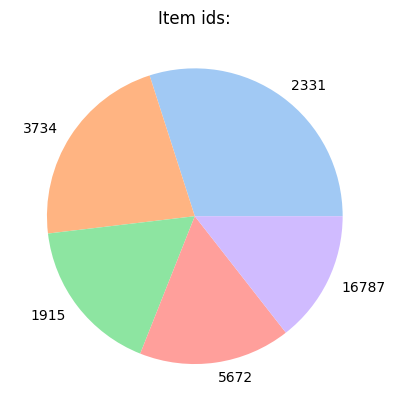

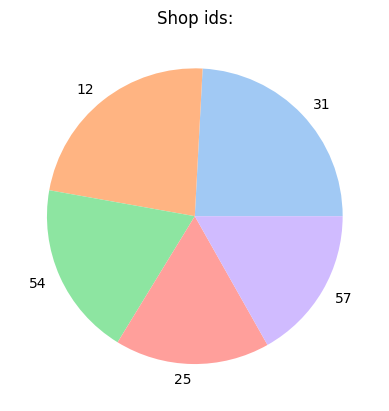

In [11]:
dqc.is_actually_a_return()

Returns happen with a lot of different type of items in a lot of different shops. The dates are also pretty diverse.

In [12]:
dqc.are_there_any_null_values()

['Table items contains 0 empty raws',
 'Table item_categories contains 0 empty raws',
 'Table sales_train contains 0 empty raws',
 'Table sample_submission contains 0 empty raws',
 'Table shops contains 0 empty raws',
 'Table test contains 0 empty raws']

No missing data.

In [13]:
dqc.are_there_any_duplicates()

"The amount of duplicated data in all the tables: 6; Tables with duplicates: ['sales_train']"

Found some duplicated rows. Only 6, so it can be safely deleted or ignored.

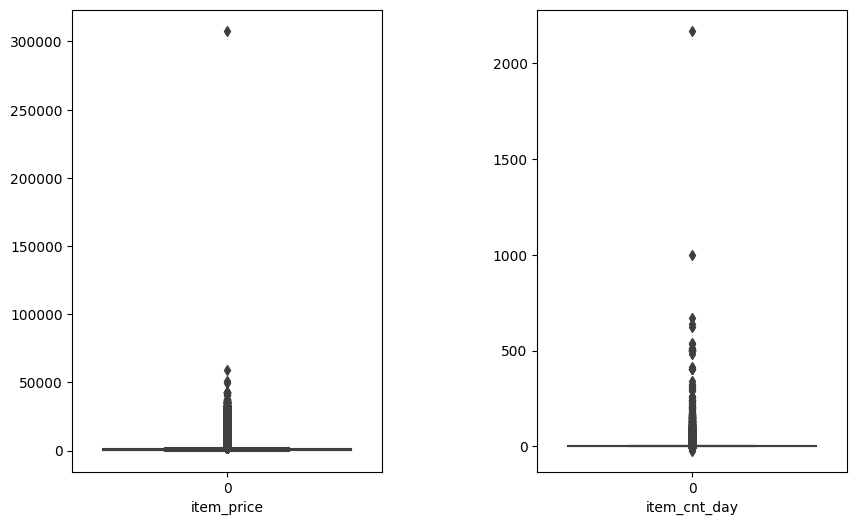

In [14]:
dqc.are_there_any_outliers()

Explicit outliers in item_price and item_cnt_day. We can look at them closely.

In [15]:
files_sales['sales_train'][files_sales['sales_train']['item_price']>=300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [16]:
files_sales['shops'][files_sales['shops']['shop_id']==12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [17]:
files_sales['items'][(files_sales['items']['item_id']==11373)|(files_sales['items']['item_id']==20949)|(files_sales['items']['item_id']==6066)]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75
11373,Доставка до пункта выдачи (Boxberry),11373,9
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


522 licenses in the set explains the standout price of the item. The same can be said about the amount of sold items per day: regular packing bags and delivery service.

We also see that people tend to buy things in greater numbers through online stores.


### Merging

In [18]:
train = pd.merge(files_sales['sales_train'], files_sales['shops'], on='shop_id', how = 'left')
train = pd.merge(train, files_sales['items'], on='item_id', how = 'left')
train = pd.merge(train, files_sales['item_categories'], on='item_category_id', how = 'left')

test = pd.merge(files_sales['test'], files_sales['shops'], on='shop_id', how = 'left')
test = pd.merge(test, files_sales['items'], on='item_id', how = 'left')
test = pd.merge(test, files_sales['item_categories'], on='item_category_id', how = 'left')
test.insert(loc=0,column='date_block_num',value=train['date_block_num'].max()+1)

## ETL

In [19]:
def length(data):

    data_len = data.shape[0]

    print(f"The amount of rows in data set: {data_len}")
    print('The amount of null values in train:',data.isna().sum().sum())

def delete_neg_in_price_and_sales(data):

    data = data[data['item_price']>0]
    data = data[data['item_cnt_day']>0]

    return data

def delete_duplicates(data):

    return data.drop_duplicates()

def date_format(data, col):

    data[col] = pd.to_datetime(data[col], format='%d.%m.%Y')

    data['year'] = data[col].dt.year
    data['month'] = data[col].dt.month
    data['day'] = data[col].dt.day

    return data

def to_file(data):

    data.to_csv('C:/datasets/sales/after_etl.csv')

    ###Only after date converting
    ## через get_dummies слишком большие размерности выходят, какой-то другой метод брать или оставлять пока?
def cat_to_num(data, col):
    cat = [col for col in data.columns if data[col].dtype=='O']
    data
    return pd.get_dummies(data, columns = col)

In [20]:
train = delete_neg_in_price_and_sales(train)
train = date_format(train, 'date')
train['year-month'] = train['date'].dt.to_period('M')
#train = train[train['item_price']<300000]
#train = train[train['item_cnt_day']<800]
train = delete_duplicates(train)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,year,month,day,year-month
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,2013,1,3,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,2013,1,15,2013-01
5,2013-01-10,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,2013,1,10,2013-01


In [21]:
train['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)',
       'Москва ТК "Буденовский" (пав.А2)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "Новый век" (Новокосино)',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       '!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Жуковский ул. Чкалова 39м?',
       'Казань ТЦ "ПаркХаус" II', 'Казань ТЦ "Бехетле"',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Серебряный Дом"', 'Н.Новгород ТРЦ "Фантастика"',
       '

In [22]:
train.loc[train['shop_name']=='!Якутск Орджоникидзе, 56 фран','shop_name'] = 'Якутск Орджоникидзе, 56'
train.loc[train['shop_name']=='!Якутск ТЦ "Центральный" фран','shop_name'] = 'Якутск ТЦ "Центральный"'
train.loc[train['shop_name']=='Москва ТК "Буденовский" (пав.К7)','shop_name'] = 'Москва ТК "Буденовский"'
train.loc[train['shop_name']=='Москва ТК "Буденовский" (пав.А2)','shop_name'] = 'Москва ТК "Буденовский"'

In [23]:
test.loc[test['shop_name']=='!Якутск Орджоникидзе, 56 фран','shop_name'] = 'Якутск Орджоникидзе, 56'
test.loc[test['shop_name']=='!Якутск ТЦ "Центральный" фран','shop_name'] = 'Якутск ТЦ "Центральный"'
test.loc[test['shop_name']=='Москва ТК "Буденовский" (пав.К7)','shop_name'] = 'Москва ТК "Буденовский"'
test.loc[test['shop_name']=='Москва ТК "Буденовский" (пав.А2)','shop_name'] = 'Москва ТК "Буденовский"'

## EDA

We should have answers to the following questions:
- What I'm working with ?
- What are the main patterns and tendencies with my data ?
- How do my data entities interact ?
- What should I do with my data to obtain good features ?
- What are the problems with the probable prediction ?
- How could I manually make predict based on data ?

In [24]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2928486.0,14.569764,9.422956,0.00,7.0,14.0,23.0,33.0
shop_id,2928486.0,33.002937,16.225431,0.00,22.0,31.0,47.0,59.0
item_id,2928486.0,10200.283934,6324.391262,0.00,4477.0,9355.0,15691.0,22169.0
item_price,2928486.0,889.466988,1727.500278,0.07,249.0,399.0,999.0,307980.0
item_cnt_day,2928486.0,1.248338,2.619589,1.00,1.0,1.0,1.0,2169.0
item_category_id,2928486.0,40.016386,17.098117,0.00,28.0,40.0,55.0,83.0
year,2928486.0,2013.776780,0.768460,2013.00,2013.0,2014.0,2014.0,2015.0
month,2928486.0,6.248410,3.535923,1.00,3.0,6.0,9.0,12.0
day,2928486.0,15.854098,8.923420,1.00,8.0,16.0,24.0,31.0


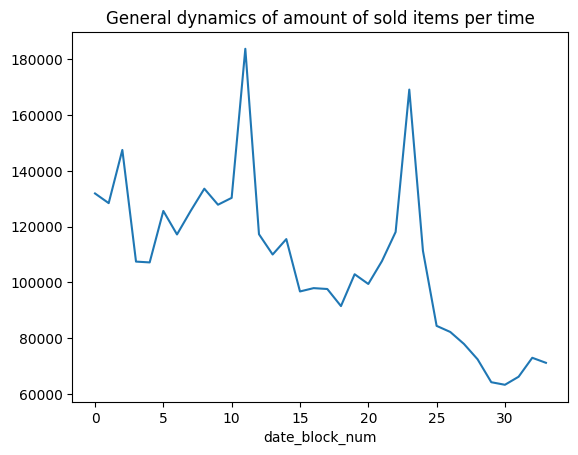

In [25]:
#general dynamics
plt.title('General dynamics of amount of sold items per time')
time_series=train.groupby(["date_block_num"])["item_cnt_day"].sum()
time_series.plot();

We clearly see that the series is not stationary. It has a downtrend and apparently some seasonality, around a year.

C:\Users\jackd\AppData\Local\Temp\ipykernel_3716\1149706082.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  date_org = train.groupby(["year-month","shop_name"])\


<AxesSubplot: xlabel='item_cnt_month', ylabel='year-month'>

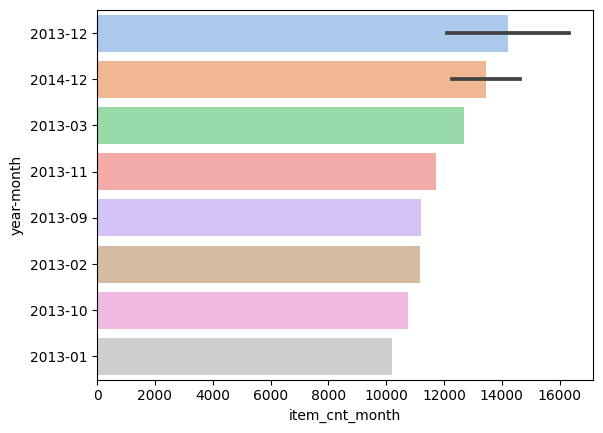

In [26]:
date_org = train.groupby(["year-month","shop_name"])\
    ["date","item_cnt_day"].agg({"item_cnt_day":"sum"}).reset_index()
date_org.columns = ['year-month','shop_name','item_cnt_month']
top = date_org.sort_values(by='item_cnt_month', ascending=False).head(10)
sns.barplot(data=top, x="item_cnt_month", y="year-month", palette='pastel')

More often people were buying in 2013, probably due to lower prices. There is also a pattern: in winter, at the end and at the beginning of the year, sales are usually higher.

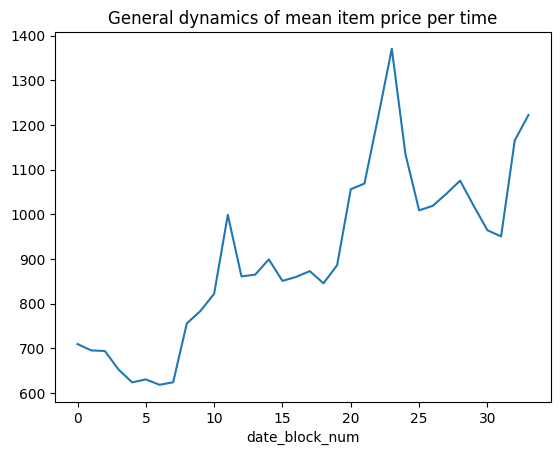

In [27]:
#####added######
plt.title('General dynamics of mean item price per time')
time_series=train.groupby(["date_block_num"])["item_price"].mean()
time_series.plot();

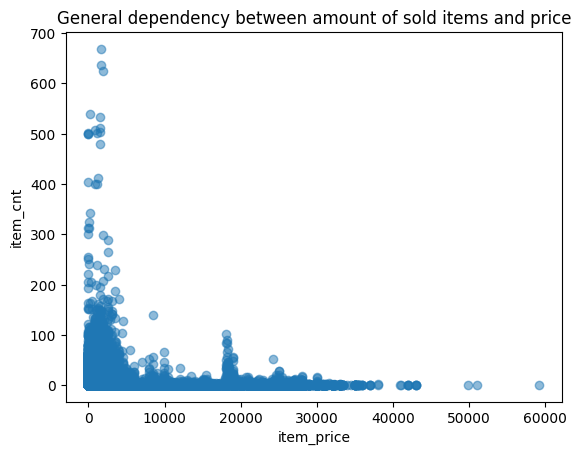

In [28]:
#####added######
t = train[train['item_price']<300000]
t = t[t['item_cnt_day']<800]
plt.title('General dependency between amount of sold items and price')
plt.ylabel('item_cnt')
plt.xlabel('item_price')
plt.scatter(t['item_price'], t['item_cnt_day'], alpha=0.5)

As we see the lesser the prices the higher the sales.

In [29]:
#####added######
shops_look_up = train.groupby(['shop_name','date_block_num','item_name']).agg({'item_cnt_day': 'sum', 'item_price':'mean'}).reset_index()
shops_look_up['income'] = round(shops_look_up['item_cnt_day']*shops_look_up['item_price'],2)
shops_look_up = shops_look_up.groupby(['shop_name','date_block_num',]).agg({'item_cnt_day': 'sum', 'item_price':'sum','income':'sum'}).reset_index()

In [30]:
shops_look_up.groupby('shop_name').agg({'item_cnt_day': ['mean','std', 'sum'],'date_block_num':'count'})

item_cnt_day               \
                                                        mean          std   
shop_name                                                                   
Адыгея ТЦ "Мега"                                  903.117647   242.055812   
Балашиха ТРК "Октябрь-Киномир"                    837.500000   164.264061   
Волжский ТЦ "Волга Молл"                         1296.147059   443.970251   
Вологда ТРЦ "Мармелад"                           1298.393939   294.944056   
Воронеж (Плехановская, 13)                       2963.441176   958.728141   
Воронеж ТРЦ "Максимир"                           1975.264706   584.759070   
Воронеж ТРЦ Сити-Парк "Град"                     1200.666667   243.097374   
Выездная Торговля                                5291.333333  1831.216080   
Жуковский ул. Чкалова 39м?                        743.121212   221.965335   
Жуковский ул. Чкалова 39м²                        572.000000          NaN   
Интернет-магазин ЧС                              2176.176471  1118.165583   
Казань ТЦ "Бехетле"                               988.150000   245.682567   
Казань ТЦ "ПаркХаус" II                          1368.058824   364.590010   
Калуга ТРЦ "XXI век"                             2097.970588   654.381016   
Коломна ТЦ "Рио"                                 1816.823529   659.769770   
Красноярск ТЦ "Взлетка Плаза"                    1295.900000   358.434594   
Красноярск ТЦ "Июнь"                             1930.029412   760.304424   
Курск ТЦ "Пушкинский"                            2166.705882   612.030477   
Москва "Распродажа"                              2936.500000   460.326515   
Москва МТРЦ "Афи Молл"                           2020.117647   496.470376   
Москва Магазин С21                               1774.529412   483.577842   
Москва ТК "Буденовский"                          2109.147059   871.708950   
Москва ТРК "Атриум"                              7124.588235  1788.532260   
Москва ТЦ "Ареал" (Беляево)                      2000.705882   626.824200   
Москва ТЦ "МЕГА Белая Дача II"                   4413.387097  1382.170917   
Москва ТЦ "МЕГА Теплый Стан" II                  5434.617647  1433.134729   
Москва ТЦ "Новый век" (Новокосино)               2029.827586   599.039950   
Москва ТЦ "Перловский"                           2344.846154   587.062361   
Москва ТЦ "Семеновский"                          9153.823529  2404.215105   
Москва ТЦ "Серебряный Дом"                       1259.142857   560.878308   
Мытищи ТРК "XL-3"                                 688.000000   300.376431   
Н.Новгород ТРЦ "РИО"                              404.750000   130.396063   
Н.Новгород ТРЦ "Фантастика"                      2033.676471   512.372481   
Новосибирск ТРЦ "Галерея Новосибирск"             333.000000          NaN   
Новосибирск ТЦ "Мега"                            1365.000000   467.616976   
Омск ТЦ "Мега"                                   1589.676471   348.602032   
РостовНаДону ТРК "Мегацентр Горизонт"             832.700000   183.438531   
РостовНаДону ТРК "Мегацентр Горизонт" Островной   450.545455   202.422016   
РостовНаДону ТЦ "Мега"                           1453.235294   601.956007   
СПб ТК "Невский Центр"                           4270.411765   835.112916   
СПб ТК "Сенная"                                  2032.920000   540.342863   
Самара ТЦ "Мелодия"                              1326.617647   442.028452   
Самара ТЦ "ПаркХаус"                             1235.323529   400.636745   
Сергиев Посад ТЦ "7Я"                            2326.235294   695.336372   
Сургут ТРЦ "Сити Молл"                           1995.088235   444.972888   
Томск ТРЦ "Изумрудный Город"                     1315.684211   419.437196   
Тюмень ТРЦ "Кристалл"                             744.869565   208.822305   
Тюмень ТЦ "Гудвин"                               2246.088235  1122.697897   
Тюмень ТЦ "Зеленый Берег"                        1477.787879   638.270356   
Уфа ТК "Центральный"                        

Based on deviation we can tell that 2 shops(Жуковский ул.Чкалова 39м² and Новосибирск ТРЦ "Галерея Новосибирск") were active only for a month. The lower std compared to mean the more homogeneous the sales are.

<AxesSubplot: xlabel='date_block_num', ylabel='item_cnt_day'>

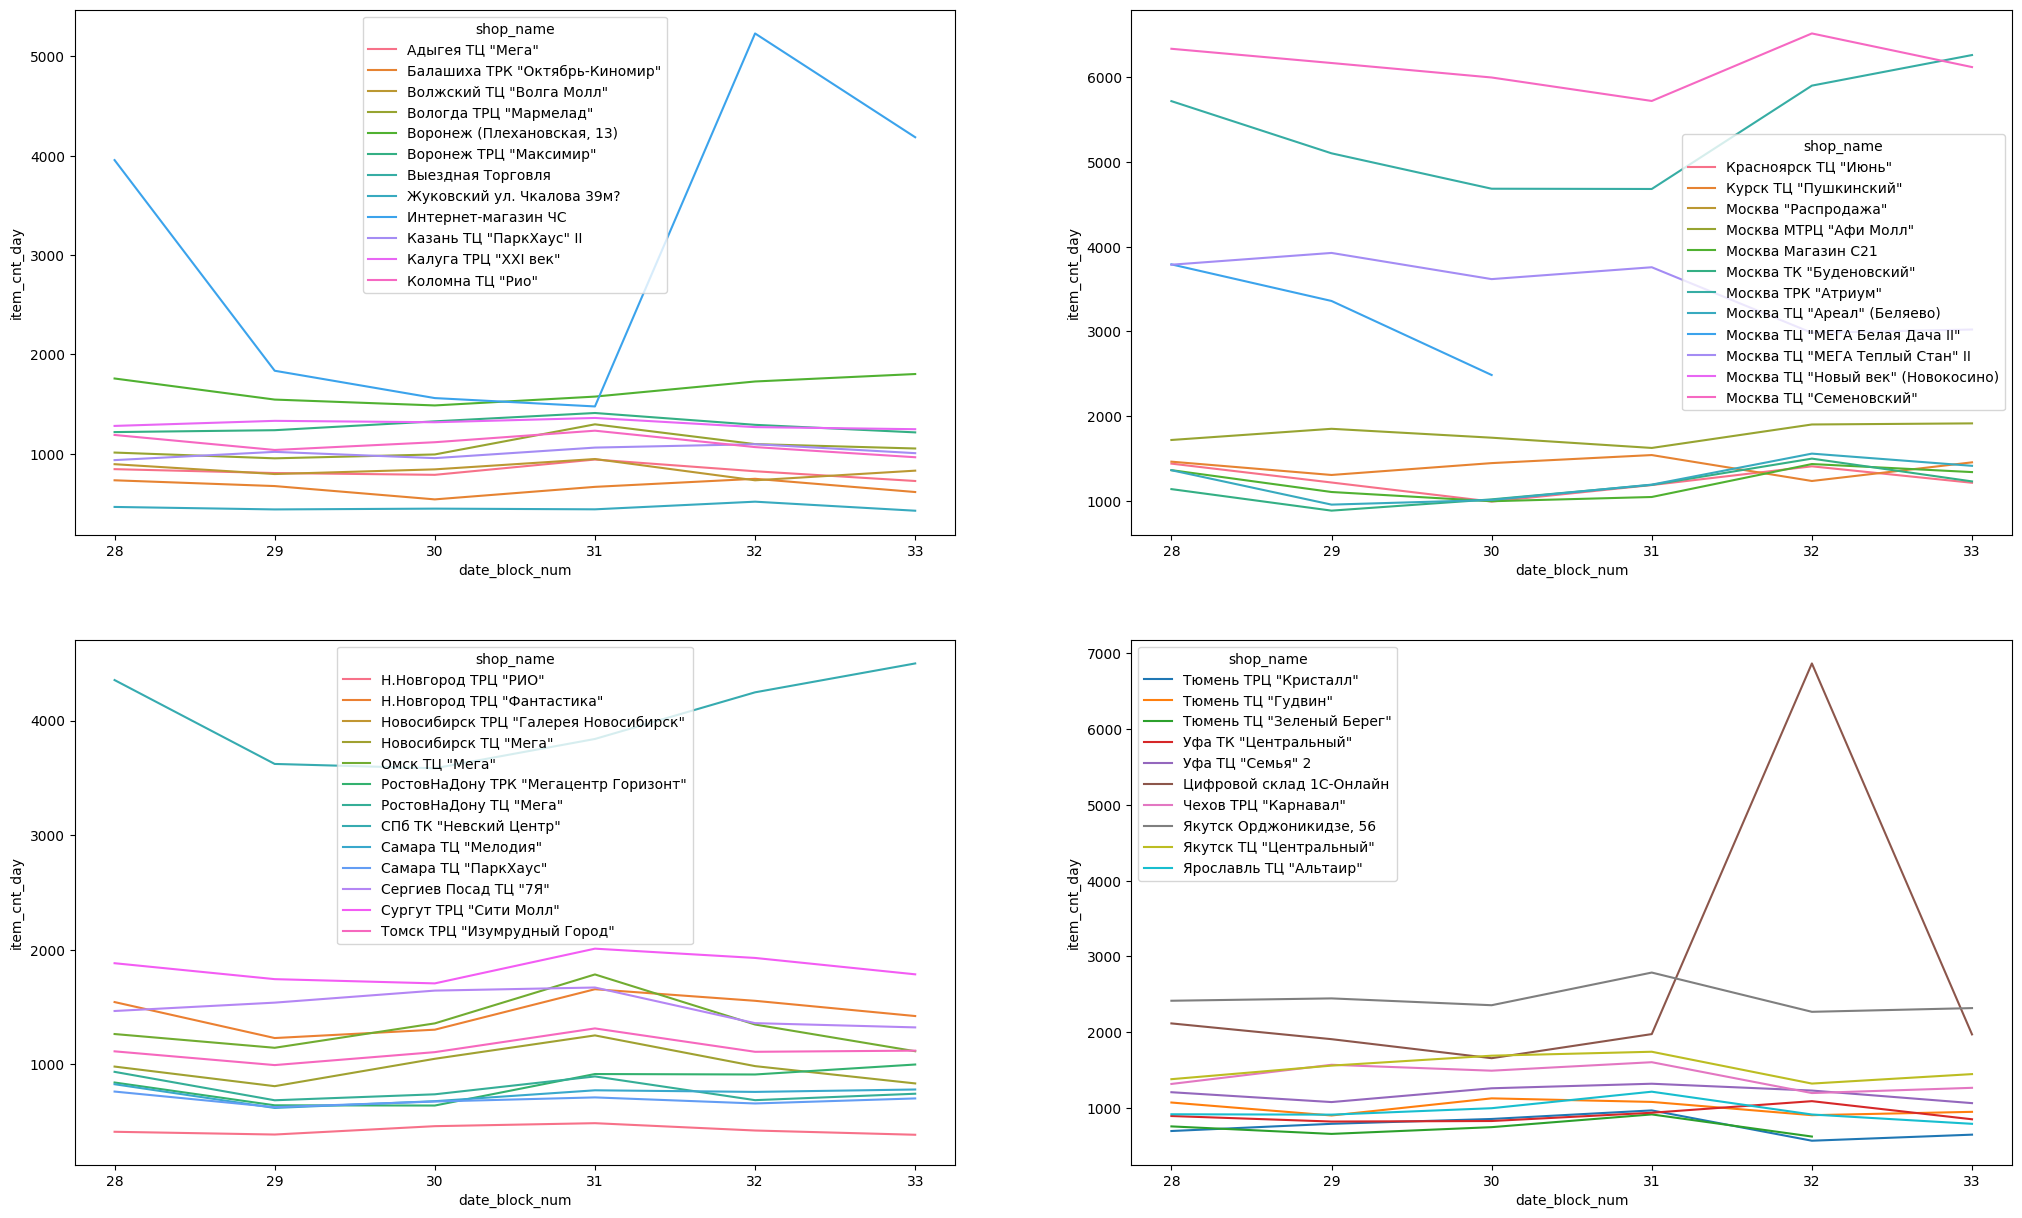

In [31]:
#####added######
shops_list = shops_look_up['shop_name'].unique()
fig, axs = plt.subplots(2, 2, figsize=(25, 15))

sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[:15]))], x="date_block_num", y="item_cnt_day", hue="shop_name", ax=axs[0][0])
sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[15:31]))], x="date_block_num", y="item_cnt_day", hue="shop_name",ax=axs[0][1])
sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[31:46]))], x="date_block_num", y="item_cnt_day", hue="shop_name",ax=axs[1][0])
sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[46:]))], x="date_block_num", y="item_cnt_day", hue="shop_name",ax=axs[1][1])

<AxesSubplot: xlabel='date_block_num', ylabel='income'>

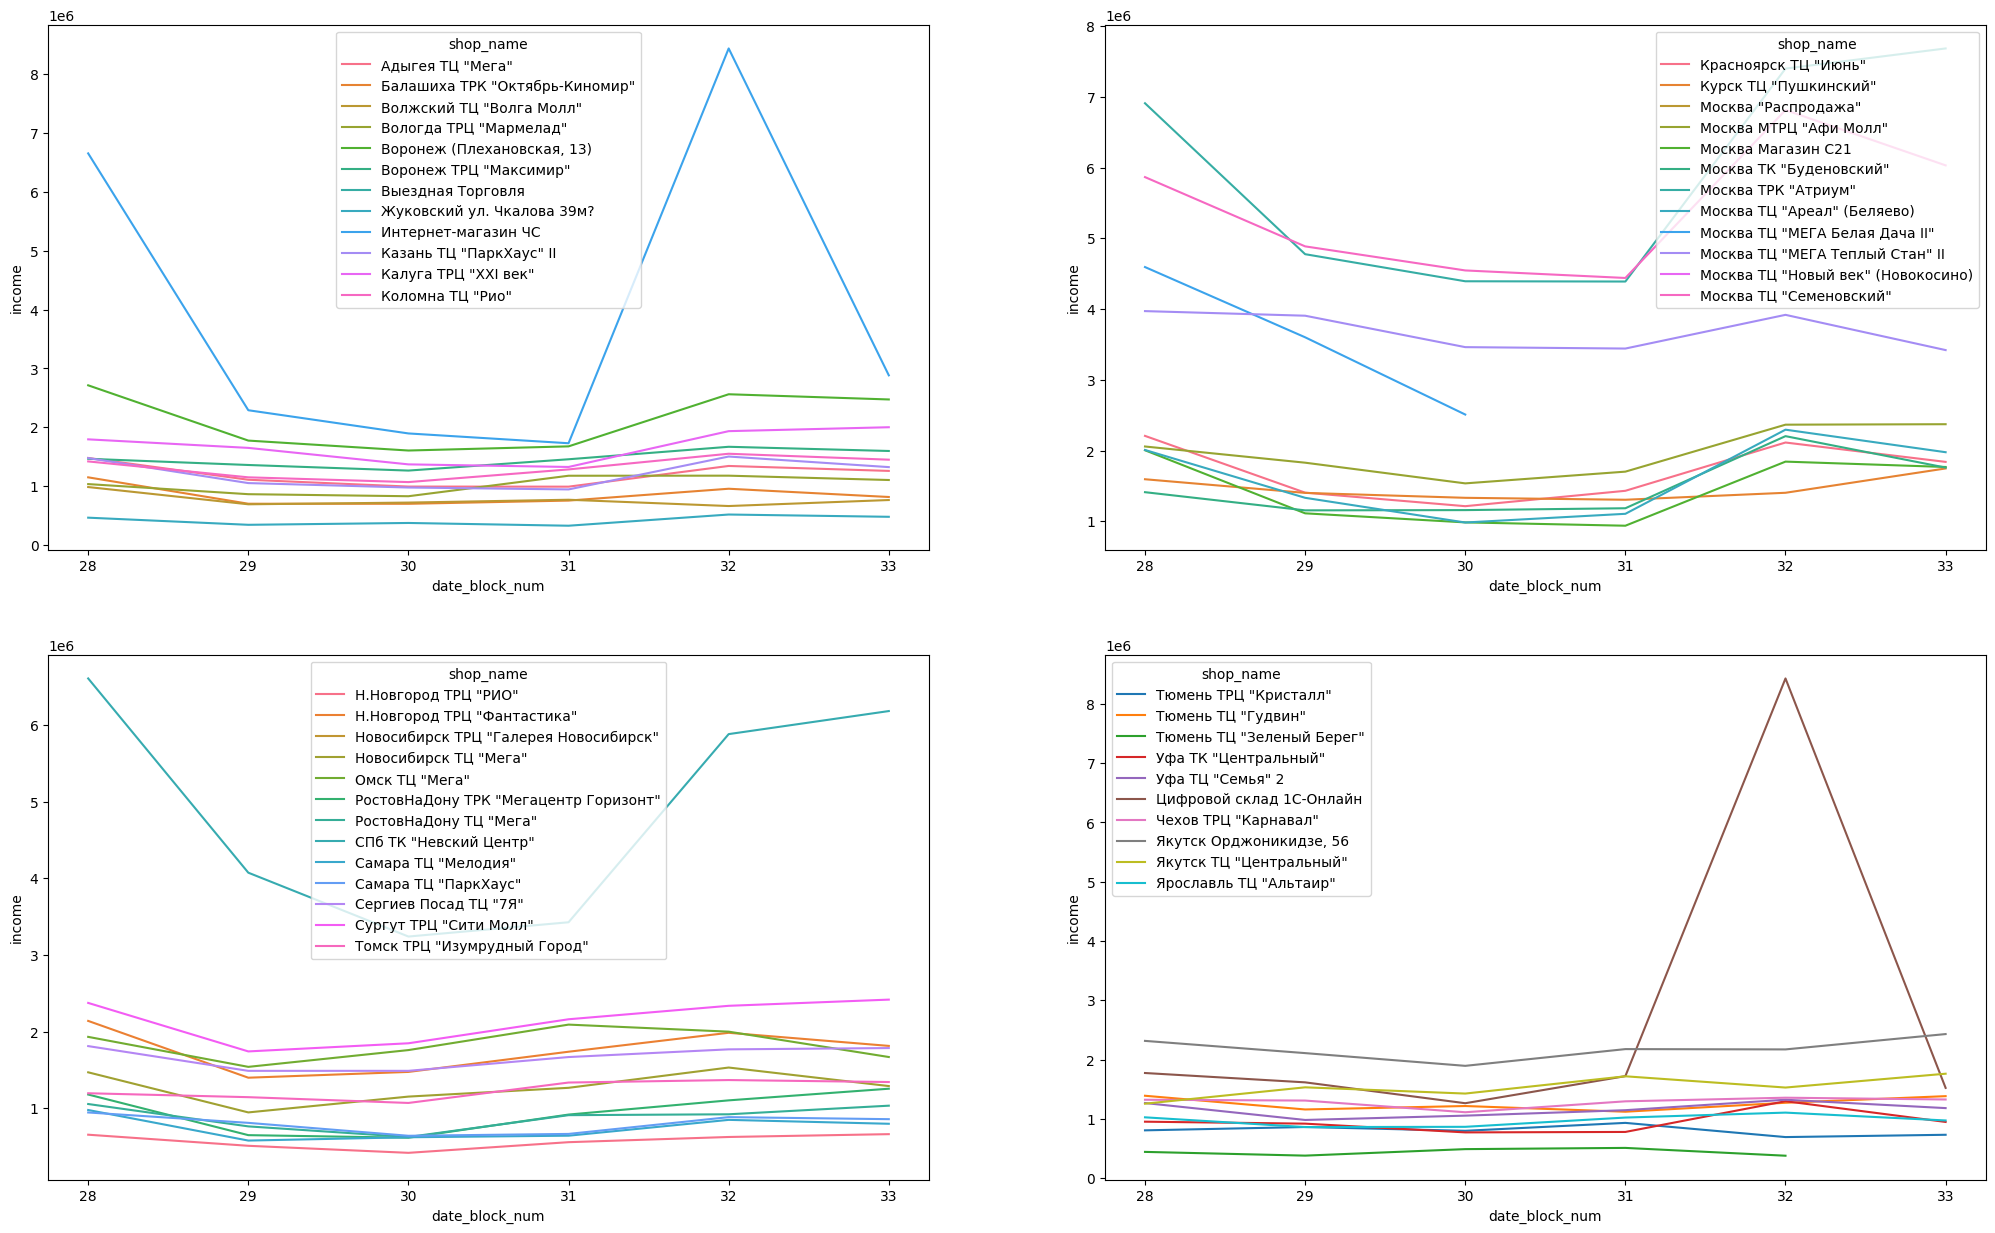

In [32]:
shops_list = shops_look_up['shop_name'].unique()
fig, axs = plt.subplots(2, 2, figsize=(25, 15))

sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[:15]))], x="date_block_num", y="income", hue="shop_name", ax=axs[0][0])
sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[15:31]))], x="date_block_num", y="income", hue="shop_name",ax=axs[0][1])
sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[31:46]))], x="date_block_num", y="income", hue="shop_name",ax=axs[1][0])
sns.lineplot(data=shops_look_up[(28<=shops_look_up['date_block_num'])&(shops_look_up['shop_name'].isin(shops_list[46:]))], x="date_block_num", y="income", hue="shop_name",ax=axs[1][1])

While looking at the last 6 month dynamics in every available shop we see that most shops are pretty stable with Москва ТЦ "Семеновский" being the leader. Online shops tend to have high peaks in block 32. 2 shops were also closed during this period of time.

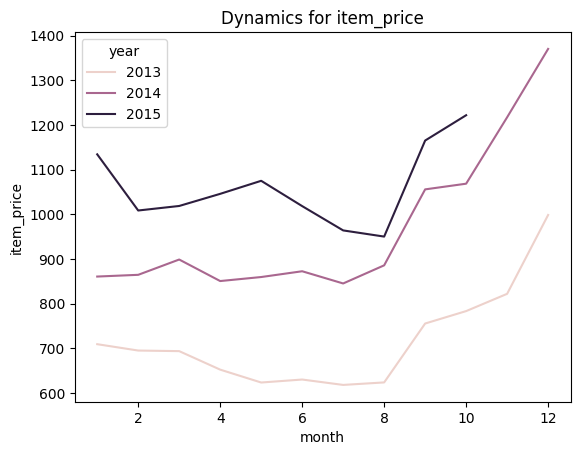

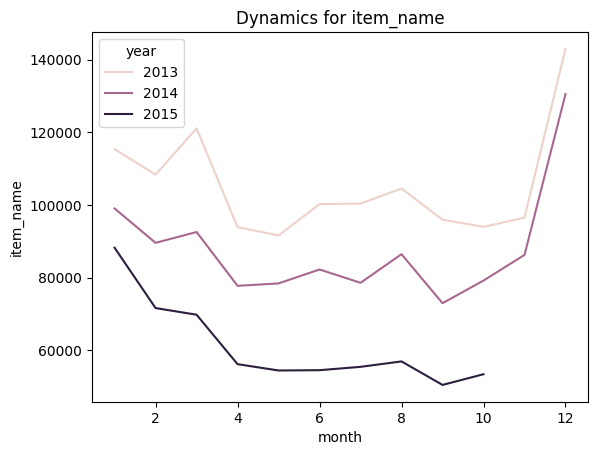

In [33]:
train_eda = train.groupby(['year','month']).agg({'item_price': 'mean','item_name': 'count',}).reset_index()
for idx, col in enumerate(train_eda.columns[2:]):
    plt.figure()
    sns.lineplot(data=train_eda, x='month', y=col, hue='year').set_title(f"Dynamics for {col}")

As expected, prices per item in 2015 is way higher than the were 1-2 years ago. For some reason every august the also tend to get bigger. We have reverse situation in amount of sold items.

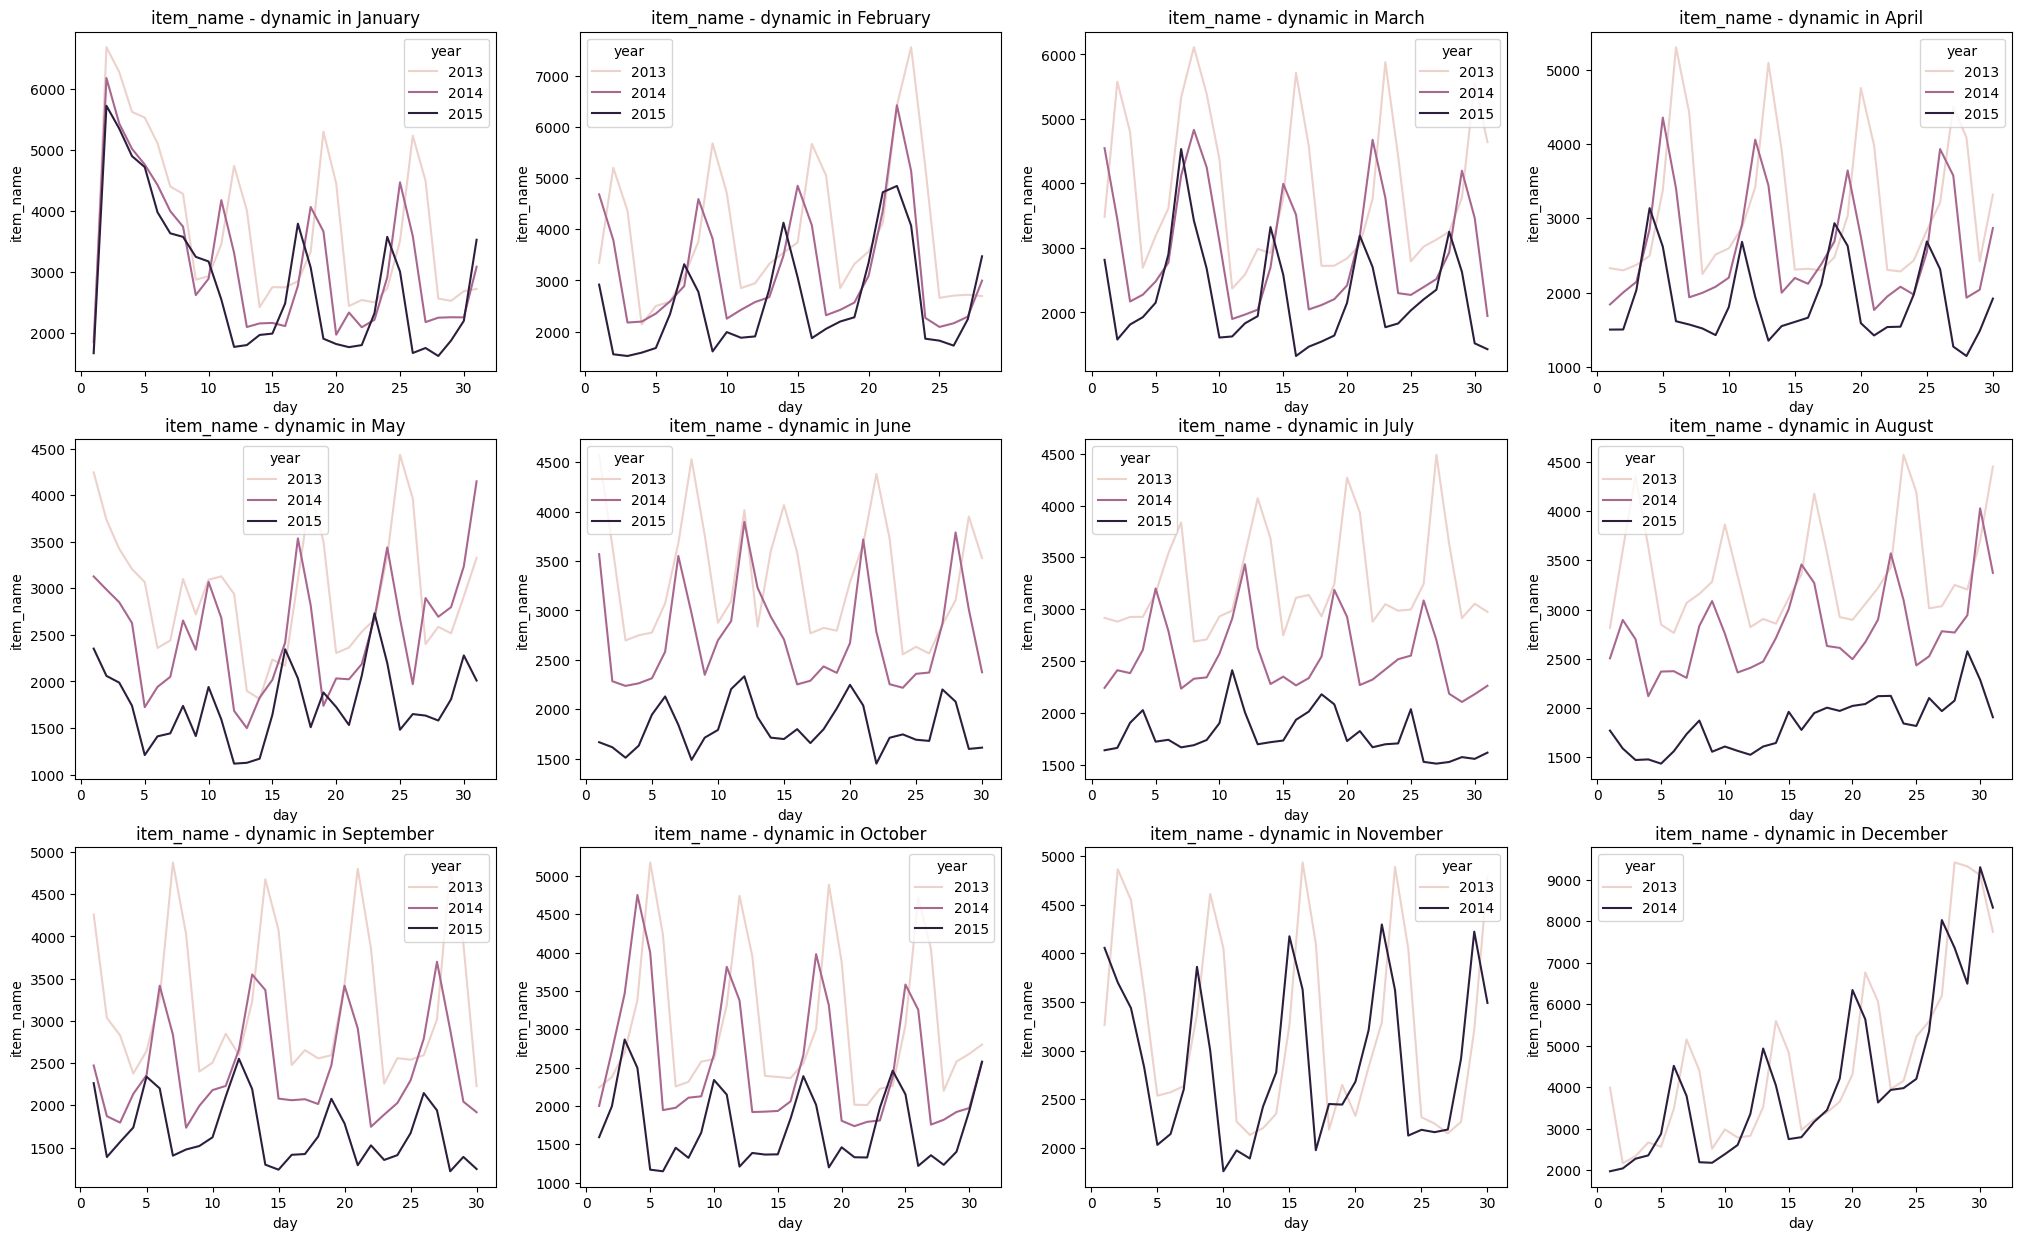

In [34]:
import calendar


p_year_patterns = train.groupby(['day', 'month', 'year']).agg({
    'item_name': 'count',
}).reset_index()

fig, axs = plt.subplots(3, 4, figsize=(25, 15))

for month in range(1,13):
    sns.lineplot(data=p_year_patterns[p_year_patterns.month == month], x='day', y='item_name', hue='year', ax=axs[(month - 1) // 4][(month - 1) % 4]).set_title(f"{col} - dynamic in {calendar.month_name[month]}")

C:\Users\jackd\AppData\Local\Temp\ipykernel_3716\2477007135.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = tr.corr(method='spearman')


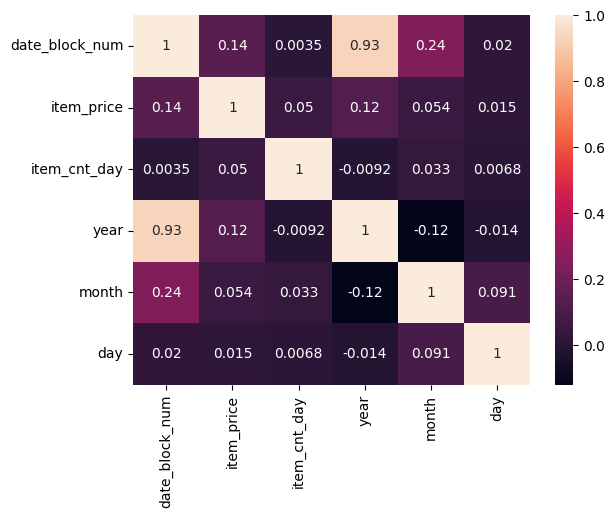

In [35]:
#for numerical feathures
tr = train.copy()
tr.drop(['shop_id','item_id','item_category_id'],inplace=True, axis=1)

corr_matrix = tr.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True);

There is a correlation between the values obtained from the date. Before modeling some of it will be removed.

The biggest correlation target formed with item_price.

### Categorial feathures

In [36]:
train['shop_name'].value_counts().head(20)

Москва ТЦ "Семеновский"            235185
Москва ТРК "Атриум"                185787
Химки ТЦ "Мега"                    143123
Москва ТЦ "МЕГА Теплый Стан" II    142018
Якутск Орджоникидзе, 56            126971
СПб ТК "Невский Центр"             109001
Москва ТЦ "МЕГА Белая Дача II"     105209
Воронеж (Плехановская, 13)          82402
Якутск ТЦ "Центральный"             76946
Чехов ТРЦ "Карнавал"                69378
Сергиев Посад ТЦ "7Я"               66219
Тюмень ТЦ "Гудвин"                  65041
Курск ТЦ "Пушкинский"               63700
Москва ТК "Буденовский"             59875
Калуга ТРЦ "XXI век"                59381
Н.Новгород ТРЦ "Фантастика"         58317
Москва МТРЦ "Афи Молл"              58007
Воронеж ТРЦ "Максимир"              57977
Сургут ТРЦ "Сити Молл"              56502
Москва ТЦ "Ареал" (Беляево)         53776
Name: shop_name, dtype: int64

As we can see names have a pattern: location - type - shop name. We can extract some information here, maybe it will be useful.

In [37]:
train['location'] = train['shop_name'].str.split(" ").str[0]
train['shop_type'] = train['shop_name'].str.split(" ").str[1]

In [38]:
test['location'] = test['shop_name'].str.split(" ").str[0]
test['shop_type'] = test['shop_name'].str.split(" ").str[1]

In [39]:
train['location'].value_counts()
train['shop_type'].value_counts()

ТЦ                1581516
ТРЦ                386415
ТК                 251306
ТРК                233852
Орджоникидзе,      126971
(Плехановская,      82402
Посад               66219
МТРЦ                58007
Магазин             45337
склад               34767
ЧС                  34264
ул.                 21896
Торговля             3743
"Распродажа"         1791
Name: shop_type, dtype: int64

In [40]:
train.loc[train['location']=='Цифровой','location'] = 'Цифровой склад'
train.loc[train['location']=='Сергиев','location'] = 'Сергиев посад'
train.loc[train['location']=='!Якутск','location'] = 'Якутск'
train.loc[train['shop_type']=='Орджоникидзе,','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='Посад','shop_type'] = 'ТЦ'
train.loc[train['shop_type']=='"Распродажа"','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='(Плехановская,','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='склад','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='ул.','shop_type'] = 'Не указан'
train.loc[train['shop_type']=='МТРЦ','shop_type'] = 'ТРЦ'
train.loc[train['shop_type']=='Торговля','shop_type'] = 'Не указан'

In [41]:
test.loc[test['location']=='Цифровой','location'] = 'Цифровой склад'
test.loc[test['location']=='Сергиев','location'] = 'Сергиев посад'
test.loc[test['location']=='!Якутск','location'] = 'Якутск'
test.loc[test['shop_type']=='Орджоникидзе,','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='Посад','shop_type'] = 'ТЦ'
test.loc[test['shop_type']=='"Распродажа"','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='(Плехановская,','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='склад','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='ул.','shop_type'] = 'Не указан'
test.loc[test['shop_type']=='МТРЦ','shop_type'] = 'ТРЦ'
test.loc[test['shop_type']=='Торговля','shop_type'] = 'Не указан'

In the names we also can see some random symbols, "!" for example.

In [42]:
train[train['shop_name'].str.contains('Якутск')==True]['shop_name'].unique()

array(['Якутск Орджоникидзе, 56', 'Якутск ТЦ "Центральный"'], dtype=object)

In [43]:
train['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский"', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "Новый век" (Новокосино)',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       'Якутск Орджоникидзе, 56', 'Якутск ТЦ "Центральный"',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Жуковский ул. Чкалова 39м?',
       'Казань ТЦ "ПаркХаус" II', 'Казань ТЦ "Бехетле"',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Серебряный Дом"', 'Н.Новгород ТРЦ "Фантастика"',
       'Чехов ТРЦ "Карнавал"', 'Химки ТЦ "Мега"',
       'Сургут ТРЦ "Си

In [44]:
train['item_category'] = train['item_category_name'].str.split(" - ").str[0]

In [45]:
test['item_category'] = test['item_category_name'].str.split(" - ").str[0]
test["subcat"] = test["item_category_name"].str.split(" - ").map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [46]:
train["subcat"] = train["item_category_name"].str.split(" - ").map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)

In [47]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,year,month,day,year-month,location,shop_type,item_category,subcat
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,2013,1,2,2013-01,Ярославль,ТЦ,Кино,Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,2013,1,3,2013-01,Москва,ТРК,Музыка,Винил
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,2013,1,6,2013-01,Москва,ТРК,Музыка,Винил
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,2013,1,15,2013-01,Москва,ТРК,Музыка,CD фирменного производства
5,2013-01-10,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,2013,1,10,2013-01,Москва,ТРК,Музыка,Музыкальное видео


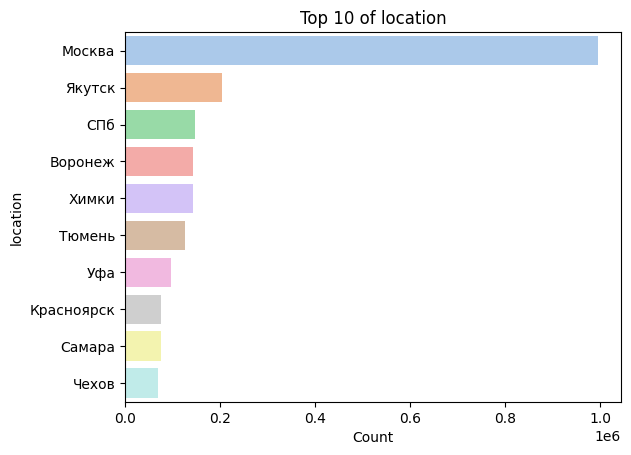

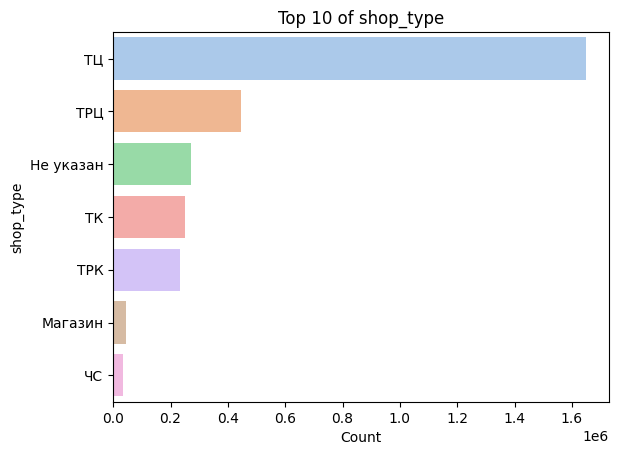

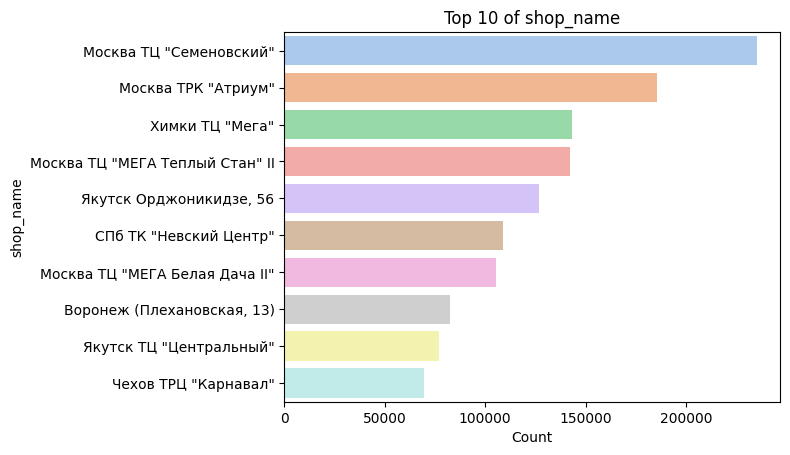

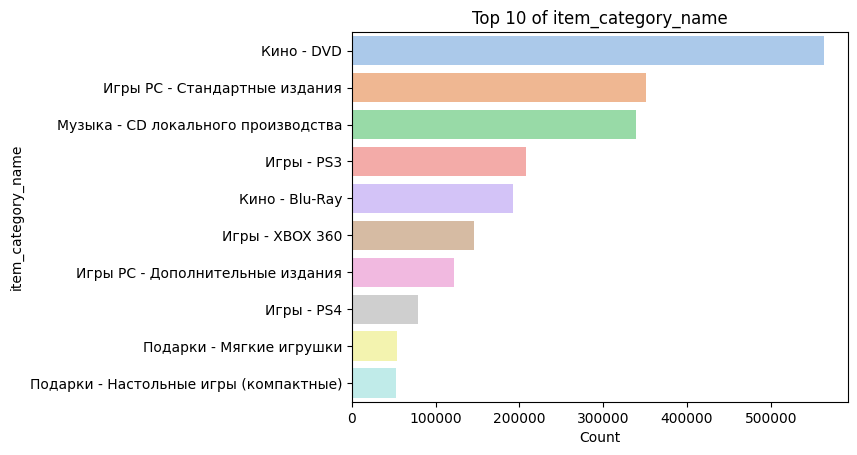

In [48]:
for col in ['location','shop_type','shop_name', 'item_category_name']:
    top_10_locs = train[col].value_counts().head(10)
    top_10_locs = top_10_locs.to_frame().reset_index()
    top_10_locs.columns = [col, 'count']
    sns.barplot(data=top_10_locs, x='count', y=col, palette = 'pastel')
    plt.title(f'Top 10 of {col}')
    plt.ylabel(col)
    plt.xlabel('Count')
    plt.show()

Moscow and it's shops are apperently the most common ones. ТЦ are quite popular.

### What can be done with data

- First of all, we can make data take form that will be more convinient for our main goal. It means that info can be grouped by shops and items, than for every group we can calculate the amount of soled products. Due to the fact that price of an item is not fixed we can try to take mean value.

- As it was stated earlier, seasonality and trend should be looked into.

- While working with time series, it is a common practice to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. We can also do that.